


#**DEEP DIVE PROJECT- Part-II/II**


---


---





In [ ]:
import numpy as np
import datetime as dt
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [ ]:
# Code snippet taken from class material
def getfile(gdrive,**kwargs): #tries to get local version and then defaults to google drive version
    loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
    out=pandas.read_pickle(loc, **kwargs)
    return out

### Import the Features
Here we import the features saved as binary files in the project folder. We have identified that gasoline prices are primarily driven by classical economic theory of supply and demand. The supply of gasoline to the US is primarily from domestic crude oil wells and imports from other nations. The US also maintains a strategic petroleum reserve to handle the disruptions in the crude oil supply chain. Demand of gasoline is primarily reflected by domestic consumption. Other than these, inflation limits the purchasing power thus affecting both production/import and consumtion of gasoline. It is usually measured as Consumer Price Index (CPI) by the Federal Bank of the US. Further, changes in taxation at federal and state level will also impact the prices, however it remains constant over a long duration. Finally, we will also use historical trends in gasoline prices to capture any missing features. To summarize, we are building a Recurrent Neural Network (RNN) to predict the weekly gasoline price based on the following features:


1.   Weekly crude oil import (Supply)
2.   Strategic Petroleum Reserve (Supply)
3.   Domestic Production (Supply)
4.   Domestic Consumption of Gas (Demand)
5.   Domestic Inflation as CPI
6.   Historical Price of Gasoline

We first load the data from pickle files saved on the google drive folder.

In [ ]:
data = {}

# CPI
fname = "https://drive.google.com/file/d/1-CKtjFCPXvt1VHtMGhIZX3ew0yGD4kqA/view?usp=share_link"
data['CPI'] = getfile(fname)
data['CPI'] = data['CPI'].reset_index(drop=True)
data['CPI'] = data['CPI'].rename(columns={"Yearmon": "Date"})
data['CPI']['Date'] = data['CPI']['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m'))
data['CPI']['Date'] = pandas.to_datetime(data['CPI']['Date'])
print(data['CPI'].head())

# Consumption
fname = "https://drive.google.com/file/d/196YZI2degsMUuY2B_dGedX2dn7YqN8eA/view?usp=share_link"
data['Consumption'] = getfile(fname)
data['Consumption'] = data['Consumption'].rename(columns={"Week of": "Date"})
print(data['Consumption'].head())

# Price
fname = "https://drive.google.com/file/d/1xZTHOvRw8dI2ZOQ2GQqa5TeEV9m7WLZ0/view?usp=share_link"
data['Price'] = getfile(fname)
print(data['Price'].head())

# Imports
fname = "https://drive.google.com/file/d/10WJGO-BH3OLLMHHVtHHek4O-odPvsJyP/view?usp=share_link"
data['NetImports'] = getfile(fname)
print(data['NetImports'].head())

# Reserve
fname = "https://drive.google.com/file/d/1TK9W9xA9tOH5qfjlmbh49L13Grj52u6f/view?usp=share_link"
data['Reserve'] = getfile(fname)[::-1]
data['Reserve'] = data['Reserve'].rename(columns={"Month": "Date"})
print(data['Reserve'].head())

# Production
fname = "https://drive.google.com/file/d/12RZ5g-tlhVPQH5hMEgMoJOXFtXG_cL35/view?usp=share_link"
data['Production'] = getfile(fname)[::-1]
data['Production'] = data['Production'].rename(columns={"Month": "Date"})
print(data['Production'].head())

        Date   CPI
0 1975-07-01  54.2
1 1975-08-01  54.3
2 1975-09-01  54.6
3 1975-10-01  54.9
4 1975-11-01  55.3
        Date  \
0 1991-02-08   
1 1991-02-15   
2 1991-02-22   
3 1991-03-01   
4 1991-03-08   

   Weekly U.S. Product Supplied of Finished Motor Gasoline Thousand Barrels per Day  
0                                               6621                                 
1                                               6433                                 
2                                               6582                                 
3                                               7224                                 
4                                               6875                                 
        Date  Price
0 1993-04-05  1.068
1 1993-04-12  1.079
2 1993-04-19  1.079
3 1993-04-26  1.086
4 1993-05-03  1.086
        Date  \
0 1991-02-08   
1 1991-02-15   
2 1991-02-22   
3 1991-03-01   
4 1991-03-08   

   Weekly U.S. Net Imports of Crude Oil and Petroleum Pr

### Find a common starting time for all data

We then truncate the data based on the available price data. We discard all of the data with an earlier date than the date of the first price data point.

In [ ]:
for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
  data[feature] = data[feature].loc[data[feature].iloc[: , 0] > (data['Price'].iloc[0 , 0] - pandas.offsets.Day(12))].reset_index(drop=True)

### Match features to the price data

Next, we match each price data-point with the feature data-points which have a date closest to the date of the price data-point. We note that we only consider feature data-points with an earlier date.

In [ ]:
data_list = []
for index, row in data['Price'].iterrows():
  for feature in ['Production', 'CPI', 'NetImports', 'Reserve', 'Consumption']:
    x = data[feature].loc[(data[feature]['Date'] < row['Date'])]
    row[feature] = x.loc[(x['Date'] - row['Date']).abs().idxmin()].iloc[1]

  data_list.append(row)

### Convert dataset into a Pandas Data Frame

In [ ]:
dataset = pandas.DataFrame(data_list)

### Visualize the dataset

z-scoring the data for easier visualization

In [ ]:
dataset_norm = dataset.copy()
dataset_norm.iloc[: , 1:] = (dataset_norm.iloc[: , 1:] - dataset_norm.iloc[: , 1:].mean()) / dataset_norm.iloc[: , 1:].std()
(dataset_norm).head()

,Date,Price,Production,CPI,NetImports,Reserve,Consumption
0,1993-04-05,-1.315651,-0.209089,-1.664355,-0.303166,-0.972198,-2.669643
1,1993-04-12,-1.303821,-0.209089,-1.664355,0.076097,-0.972198,-2.921803
2,1993-04-19,-1.303821,-0.209089,-1.664355,-0.179352,-0.972198,-1.768210
3,1993-04-26,-1.296293,-0.209089,-1.664355,0.013277,-0.972198,-2.023389
4,1993-05-03,-1.296293,-0.124841,-1.659050,0.197825,-0.965331,-1.905614


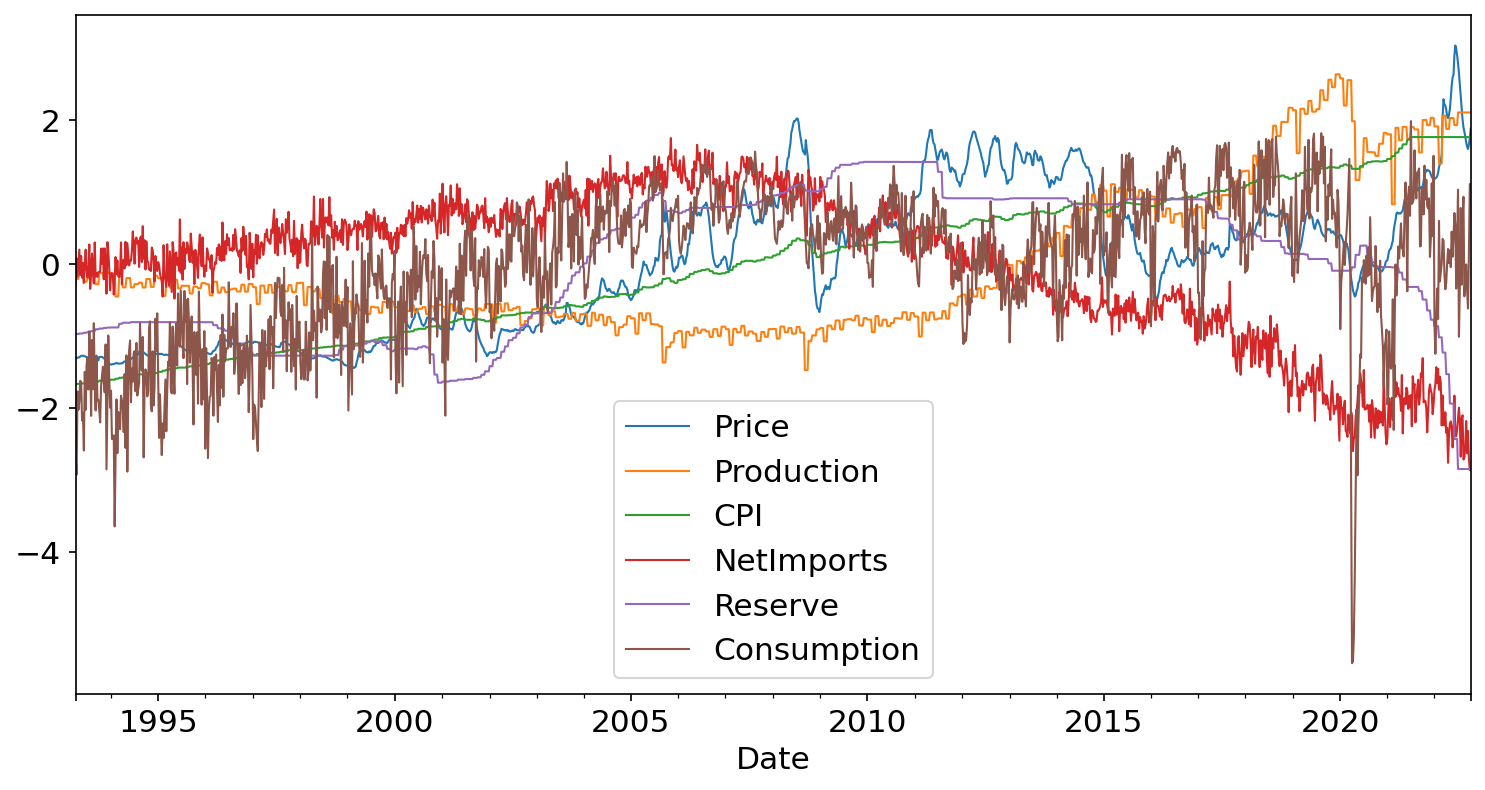

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
df = dataset_norm.plot(x='Date', linewidth=1, ax = plt.gca())

# plt.plot(dataset.iloc[: , 0], (dataset.iloc[: , 1:] - dataset.iloc[: , 1:].mean()) / dataset.iloc[: , 1:].std(), linewidth=1)
# plt.legend()
# plt.show()

### Train-Validation-Test Split

Before we extract any information from the data we split them into train, validation and test data. We take the last 10% of the data as the test set and 20% as the validation set. 

In [ ]:
trainset = dataset[:-int(0.3 * len(dataset))].copy()
validationset = dataset[-int(0.3 * len(dataset)):-int(0.1 * len(dataset))].copy()
testset = dataset[-int(0.1 * len(dataset)):].copy()
trainset = trainset.drop(["Date"], axis = 1)
validationset = validationset.drop(["Date"], axis = 1)
testset = testset.drop(["Date"], axis = 1)
print("trainset length: "+ str(len(trainset))+ " | validationset length: " + str(len(validationset)) +  " | testset length: " + str(len(testset)) + " | Complete dataset length: " + str(len(dataset)))

trainset length: 1079 | validationset length: 308 | testset length: 154 | Complete dataset length: 1541


Normalize the train data, as well as the test data based on the mean and std values of the train data.

In [ ]:
from sklearn.preprocessing import StandardScaler

names = dataset.columns[1:len(dataset)]
scaler = StandardScaler()
scaler = scaler.fit(trainset)
train_df = pandas.DataFrame(scaler.transform(trainset))
train_df.columns = names

test_df = pandas.DataFrame(scaler.transform(testset))
test_df.columns = names

val_df = pandas.DataFrame(scaler.transform(validationset))
val_df.columns = names

train_df2 = pandas.concat([train_df, train_df['Price'].shift(1)], axis=1, ignore_index=True)[1:]
val_df2 = pandas.concat([val_df, val_df['Price'].shift(1)], axis=1, ignore_index=True)[1:]
test_df2 = pandas.concat([test_df, test_df['Price'].shift(1)], axis=1, ignore_index=True)[1:]

y_train = train_df2.iloc[: , 0].to_numpy()
X_train = train_df2.iloc[: , 1:].to_numpy()

y_val = val_df2.iloc[: , 0].to_numpy()
X_val = val_df2.iloc[: , 1:].to_numpy()

y_test = test_df2.iloc[: , 0].to_numpy()
X_test = test_df2.iloc[: , 1:].to_numpy()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train)) 
train_dataloader = DataLoader(train_dataset, batch_size=4) 

val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val)) 
val_dataloader = DataLoader(val_dataset) 

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test)) 
test_dataloader = DataLoader(test_dataset) 


---


## Deep Neural Network




---


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
  def __init__(self):
      super(NeuralNetwork, self).__init__()
      self.layer1 = nn.Linear(6, 16) # input: X.shape[1]=5, output: 
      self.layer2 = nn.Linear(16, 32)
      self.layer3 = nn.Linear(32, 16)
      self.layer4 = nn.Linear(16, 1)
      self.m2 = nn.Dropout(p=0.2)
      self.m1 = nn.Dropout(p=0.2)
  def forward(self, x):
      x = torch.relu(self.layer1(x))
      x = torch.relu(self.layer2((x)))
      x = torch.relu(self.layer3((x)))
      x = self.layer4(x)
      return x

model = NeuralNetwork().to(device)
print(model)

import torch.optim as optim
from tqdm import tqdm

opt = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

min_val_loss = 10000
tr_loss_list,  vl_loss_list, tt_loss_list = [], [], []
for ep in tqdm(range(200)):
  model.train()
  tr_loss, vl_loss, tt_loss = 0., 0., 0.
  for batch in train_dataloader:
    X, y = batch[0], batch[1]
    X, y = X.to(device).float(), y.to(device).float()

    y_hat = model(X)
    l = loss(y, y_hat)

    opt.zero_grad()
    l.backward()
    opt.step()

    tr_loss += l.data.item()

  tr_loss_list.append(tr_loss / len(train_dataloader))

  model.eval()
  with torch.no_grad():
    for batch in test_dataloader:
      X, y = batch[0], batch[1]
      X, y = X.to(device).float(), y.to(device).float()

      y_hat = model(X)
      l = loss(y, y_hat)

      tt_loss += l.data.item()

    tt_loss_list.append(tt_loss / len(test_dataloader))

    for batch in val_dataloader:
      X, y = batch[0], batch[1]
      X, y = X.to(device).float(), y.to(device).float()

      y_hat = model(X)
      l = loss(y, y_hat)

      vl_loss += l.data.item()

    vl_loss_list.append(vl_loss / len(val_dataloader))

NeuralNetwork(
  (layer1): Linear(in_features=6, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=1, bias=True)
  (m2): Dropout(p=0.2, inplace=False)
  (m1): Dropout(p=0.2, inplace=False)
)


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same si

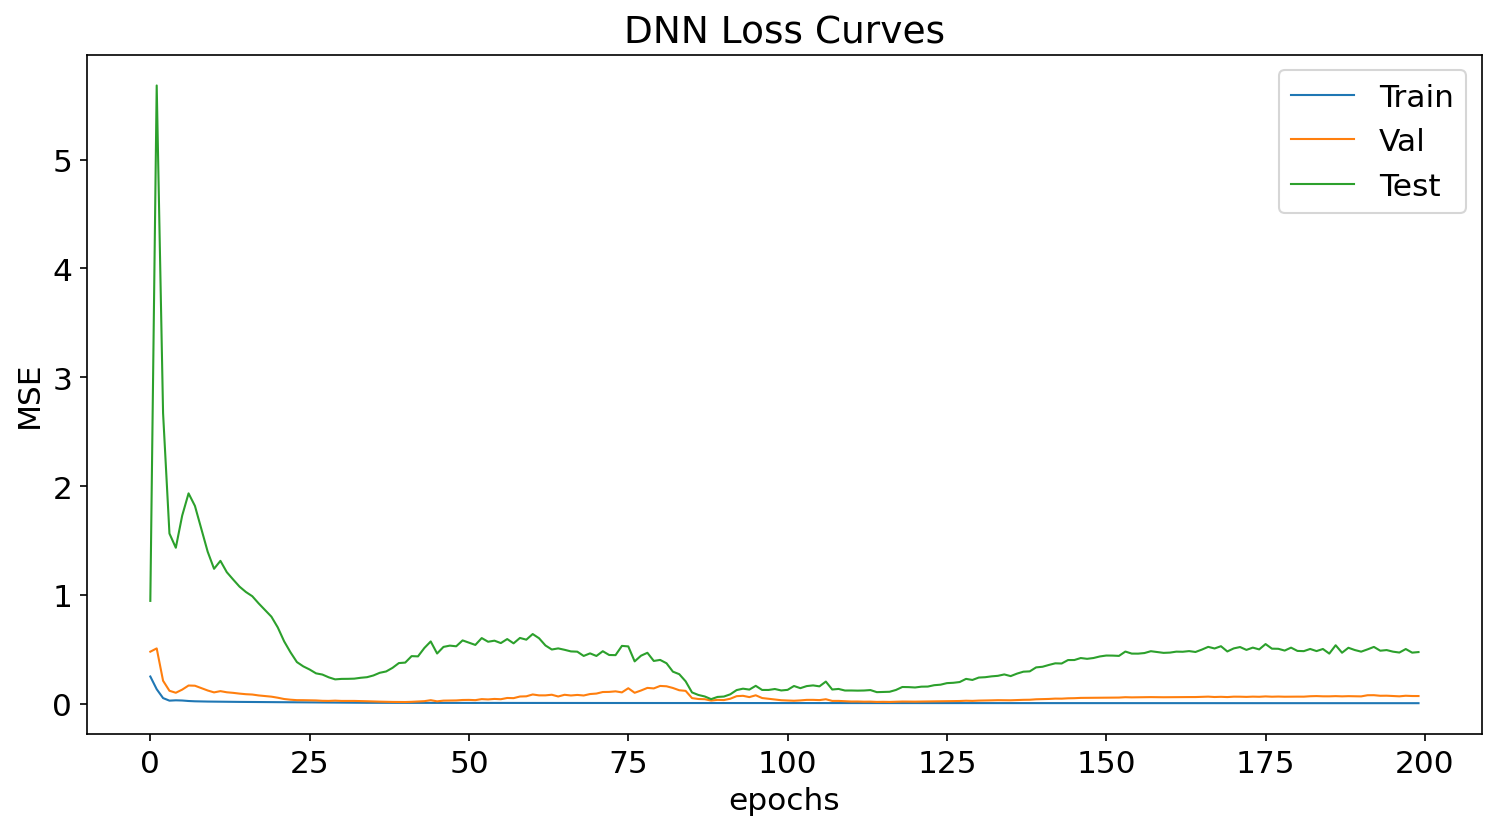

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(tr_loss_list, linewidth=1, label='Train')
plt.plot(vl_loss_list, linewidth=1, label='Val')
plt.plot(tt_loss_list, linewidth=1, label='Test')
plt.title('DNN Loss Curves')
plt.ylabel('MSE')
plt.xlabel('epochs')
# plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
model.eval()
pred_val = []
with torch.no_grad():
  for batch in tqdm(val_dataloader):
    X, y = batch[0], batch[1]
    X, y = X.to(device).float(), y.to(device).float()

    y_hat = model(X)

    pred_val.append(y_hat.cpu().data.item())

pred_test = []
with torch.no_grad():
  for batch in tqdm(test_dataloader):
    X, y = batch[0], batch[1]
    X, y = X.to(device).float(), y.to(device).float()

    y_hat = model(X)

    pred_test.append(y_hat.cpu().data.item())

100%|██████████| 153/153 [00:00<00:00, 2748.86it/s]


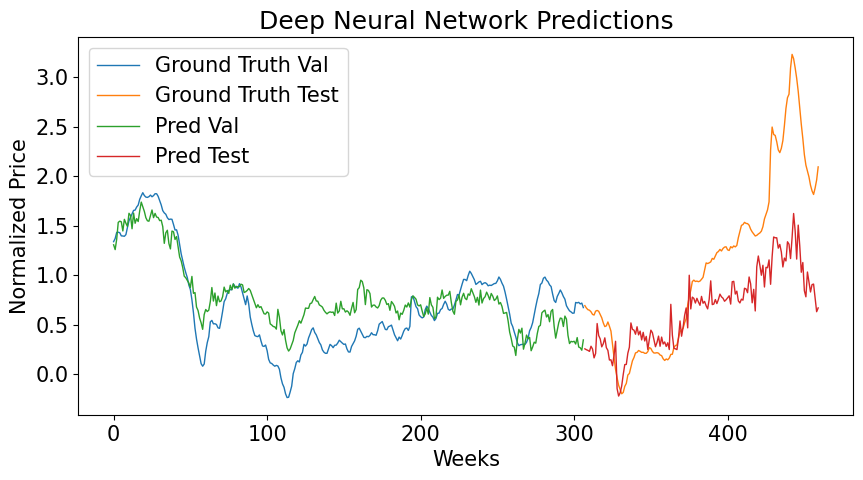

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(y_val, linewidth=1, label='Ground Truth Val')
plt.plot(np.arange(len(y_test)) + len(y_val), y_test, linewidth=1, label='Ground Truth Test')
plt.plot((pred_val), linewidth=1, label='Pred Val')
plt.plot(np.arange(len(y_test)) + len(y_val), pred_test, linewidth=1, label='Pred Test')
plt.title('Deep Neural Network Predictions')
plt.ylabel('Normalized Price')
plt.xlabel('Weeks')
plt.legend()
plt.show()

In [ ]:
print('Validation Mean Absolute Error:', np.abs(y_val - pred_val).mean())
print('Test Mean Absolute Error:', np.abs(y_test - pred_test).mean())
print()

print('Validation Mean Square Error:', ((y_val - pred_val)**2).mean())
print('Test Mean Square Error:', ((y_test - pred_test)**2).mean())

Validation Mean Absolute Error: 0.2305187121457148
Test Mean Absolute Error: 0.5160287492225207

Validation Mean Square Error: 0.07183579557706221
Test Mean Square Error: 0.47570824368342457




---


## Convolutional Neural Network

Next, we use a convolutional neural network in order to take advantage of the temporal dynamics of the price and feature data. We make sure to use causal convolution in order to predict each price sample using only prior data and not any future data. 


---



In [ ]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
  def __init__(self):
      super(CNN, self).__init__()
      self.layer1 = CausalConv1d(6, 32, 1) # input: X.shape[1]=5, output: 
      self.layer2 = CausalConv1d(32, 16, 16)
      # self.layer3 = CausalConv1d(16, 16, 16)
      self.layer4 = CausalConv1d(16, 1, 4)
      
      # self.m2 = nn.Dropout(p=0.2)
      # self.m1 = nn.Dropout(p=0.2)
  def forward(self, x):
      x = torch.relu(self.layer1(x))
      x = torch.relu(self.layer2((x)))[:,:, :-self.layer2.padding[0]]
      # x = torch.relu(self.layer3((x)))[:,:, :-self.layer3.padding[0]]
      x = self.layer4((x))[:,:, :-self.layer4.padding[0]]
      # x = self.layer4(x)
      return x

In [ ]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=64):
        self.X = X
        self.y = y.unsqueeze(0)
        
        self.seq_len = seq_len

    def __len__(self):
        return self.X.shape[-1] - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[:, index:index+self.seq_len], self.y[:, index:index+self.seq_len])

In [ ]:
train_dataset = TimeseriesDataset(torch.tensor(X_train).T, torch.tensor(y_train).T) 
train_dataloader = DataLoader(train_dataset, batch_size=4) 

val_dataset = TimeseriesDataset(torch.tensor(X_val).T, torch.tensor(y_val).T) 
val_dataloader = DataLoader(val_dataset) 

test_dataset = TimeseriesDataset(torch.tensor(X_test).T, torch.tensor(y_test).T) 
test_dataloader = DataLoader(test_dataset) 

<ipython-input-20-d450453f94e7>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  train_dataset = TimeseriesDataset(torch.tensor(X_train).T, torch.tensor(y_train).T)


In [ ]:
model = CNN().to(device)
print(model)

CNN(
  (layer1): Conv1d(6, 32, kernel_size=(1,), stride=(1,))
  (layer2): Conv1d(32, 16, kernel_size=(16,), stride=(1,), padding=(15,))
  (layer4): Conv1d(16, 1, kernel_size=(4,), stride=(1,), padding=(3,))
)


In [ ]:
opt = optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

min_val_loss = 10000
tr_loss_list,  vl_loss_list, tt_loss_list = [], [], []
for ep in tqdm(range(200)):
  model.train()
  tr_loss, vl_loss, tt_loss = 0., 0., 0.
  for batch in train_dataloader:
    X, y = batch[0], batch[1]
    X, y = X.to(device).float(), y.to(device).float()

    y_hat = model(X)
    l = loss(y, y_hat)

    opt.zero_grad()
    l.backward()
    opt.step()

    tr_loss += l.data.item()

  tr_loss_list.append(tr_loss / len(train_dataloader))

  model.eval()
  with torch.no_grad():
    for batch in test_dataloader:
      X, y = batch[0], batch[1]
      X, y = X.to(device).float(), y.to(device).float()

      y_hat = model(X)
      l = loss(y, y_hat)

      tt_loss += l.data.item()

    tt_loss_list.append(tt_loss / len(test_dataloader))

    for batch in val_dataloader:
      X, y = batch[0], batch[1]
      X, y = X.to(device).float(), y.to(device).float()

      y_hat = model(X)
      l = loss(y, y_hat)

      vl_loss += l.data.item()

    vl_loss_list.append(vl_loss / len(val_dataloader))

100%|██████████| 200/200 [02:48<00:00,  1.18it/s]


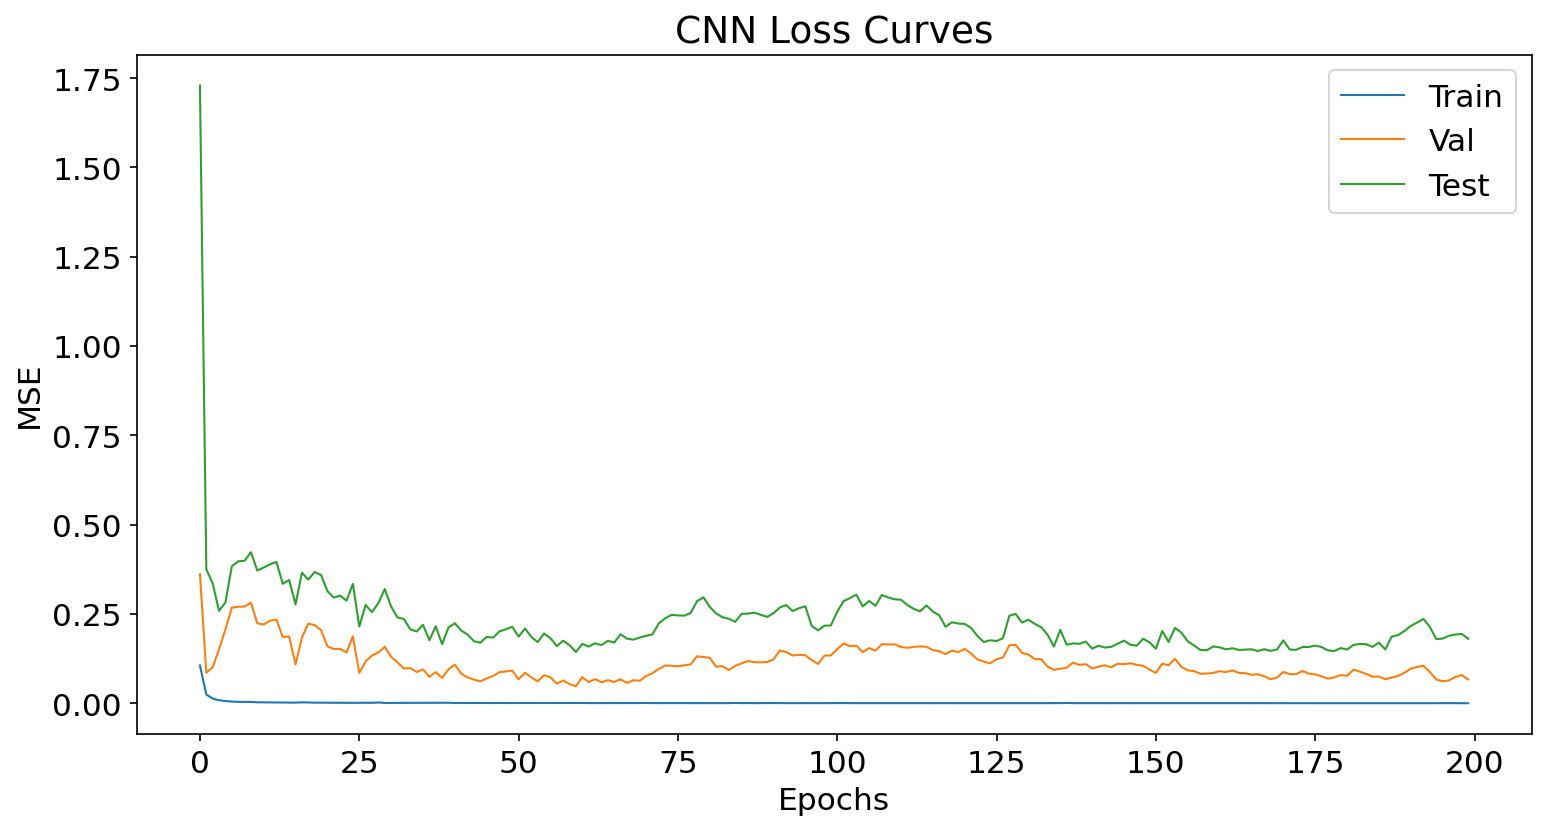

In [ ]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot(tr_loss_list, linewidth=1, label='Train')
plt.plot(vl_loss_list, linewidth=1, label='Val')
plt.plot(tt_loss_list, linewidth=1, label='Test')
plt.title('CNN Loss Curves')
plt.ylabel('MSE')
plt.xlabel('Epochs')
# plt.ylim([0,1])
plt.legend()
plt.show()

In [ ]:
model.eval()
pred_val = []
with torch.no_grad():
  for j, batch in tqdm(enumerate(val_dataloader)):
    X, y = batch[0], batch[1]
    X, y = X.to(device).float(), y.to(device).float()

    y_hat = model(X)
    if j == 0:
      pred_val = (y_hat[0, 0].cpu().tolist())
    else:
      pred_val.append(y_hat[:, :, -1].cpu().data.item())

pred_test = []
with torch.no_grad():
  for j, batch in tqdm(enumerate(test_dataloader)):
    X, y = batch[0], batch[1]
    X, y = X.to(device).float(), y.to(device).float()

    y_hat = model(X)
    if j == 0:
      pred_test = (y_hat[0, 0].cpu().tolist())
    else:
      pred_test.append(y_hat[:, :, -1].cpu().data.item())


# test_df2 = pandas.concat([val_df[-20:], test_df], axis=0, ignore_index=True)
# test_df2 = pandas.concat([test_df2, test_df2['Price'].shift(1)], axis=1, ignore_index=True)[1:]

# y_test = test_df2.iloc[: , 0].to_numpy()
# X_test = test_df2.iloc[: , 1:].to_numpy()

# y_test = y_test[20:]
# pred_test = pred_test[20:]

244it [00:00, 1633.97it/s]
90it [00:00, 1423.88it/s]


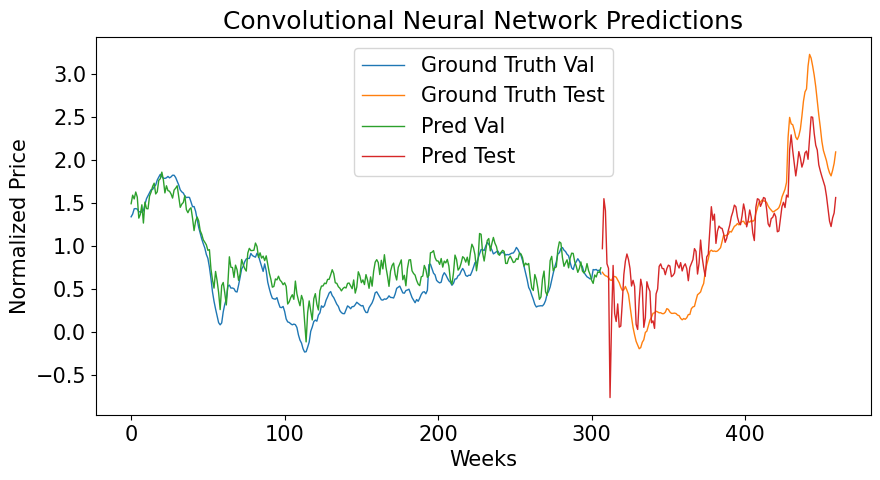

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(y_val, linewidth=1, label='Ground Truth Val')
plt.plot(np.arange(len(y_test)) + len(y_val), y_test, linewidth=1, label='Ground Truth Test')
plt.plot((pred_val), linewidth=1, label='Pred Val')
plt.plot(np.arange(len(y_test)) + len(y_val), pred_test, linewidth=1, label='Pred Test')
plt.title('Convolutional Neural Network Predictions')
plt.ylabel('Normalized Price')
plt.xlabel('Weeks')
plt.legend()
plt.show()

In [ ]:
print('Validation Mean Absolute Error:', np.abs(y_val - pred_val).mean())
print('Test Mean Absolute Error:', np.abs(y_test - pred_test).mean())
print()

print('Validation Mean Square Error:', ((y_val - pred_val)**2).mean())
print('Test Mean Square Error:', ((y_test - pred_test)**2).mean())

Validation Mean Absolute Error: 0.17697462965149066
Test Mean Absolute Error: 0.3544178986167641

Validation Mean Square Error: 0.045647461966138
Test Mean Square Error: 0.18600662235528334
